In [1]:
import sys
sys.path.append('..')

from ml.dataset.corpus import *
from ml.dataset.mappers_preprocess import *
from ml.dataset.mappers_simplify import *
from ml.dataset.mappers_prepare import *
from ml.dataset.pipeline import *
from IPython.core.display import HTML, display

import matplotlib.pyplot as plt
import pandas as pd
import pychord
import music21
music21.environment.set('musescoreDirectPNGPath', '/usr/bin/musescore')

/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
corpus = SongCorpus()

In [3]:
corpus.load_from_file('/home/sharik/code/Innprak/simple_dataset/guitar_dataset.pickle')

In [4]:
corpus.pipeline.mappers = [SplitToGcdMapper(what='all', min_gcd=32), VarietyMapper(), ClassifyChordsMapper()]
corpus.apply_pipeline_to_memory()

{"('SplitToGcdMapper', 'gcd')": {16: 22723,
  48: 339,
  32: 2463,
  64: 1304,
  128: 990,
  4: 1921,
  192: 22,
  8: 2844,
  96: 258,
  24: 10,
  256: 15,
  12: 4,
  80: 1,
  160: 30,
  20: 2},
 "('VarietyMapper', 'variety')": {0.38650306748466257: 1,
  0.6142857142857143: 1,
  0.6343283582089553: 1,
  0.2857142857142857: 4,
  0.3076923076923077: 4,
  0.23404255319148937: 3,
  0.2608695652173913: 5,
  0.16666666666666666: 1,
  0.4807692307692308: 1,
  0.46296296296296297: 1,
  0.2391304347826087: 1,
  0.35714285714285715: 9,
  1.0: 84,
  0.15492957746478872: 2,
  0.4878048780487805: 1,
  0.7258064516129032: 1,
  0.6714285714285714: 1,
  0.5842105263157895: 1,
  0.5894736842105263: 1,
  0.4: 7,
  0.3958333333333333: 1,
  0.22580645161290322: 10,
  0.375: 6,
  0.6153846153846154: 3,
  0.41025641025641024: 2,
  0.17647058823529413: 2,
  0.2542372881355932: 1,
  0.2710843373493976: 4,
  0.2962962962962963: 2,
  0.29365079365079366: 1,
  0.2966101694915254: 4,
  0.32142857142857145: 1,
  0

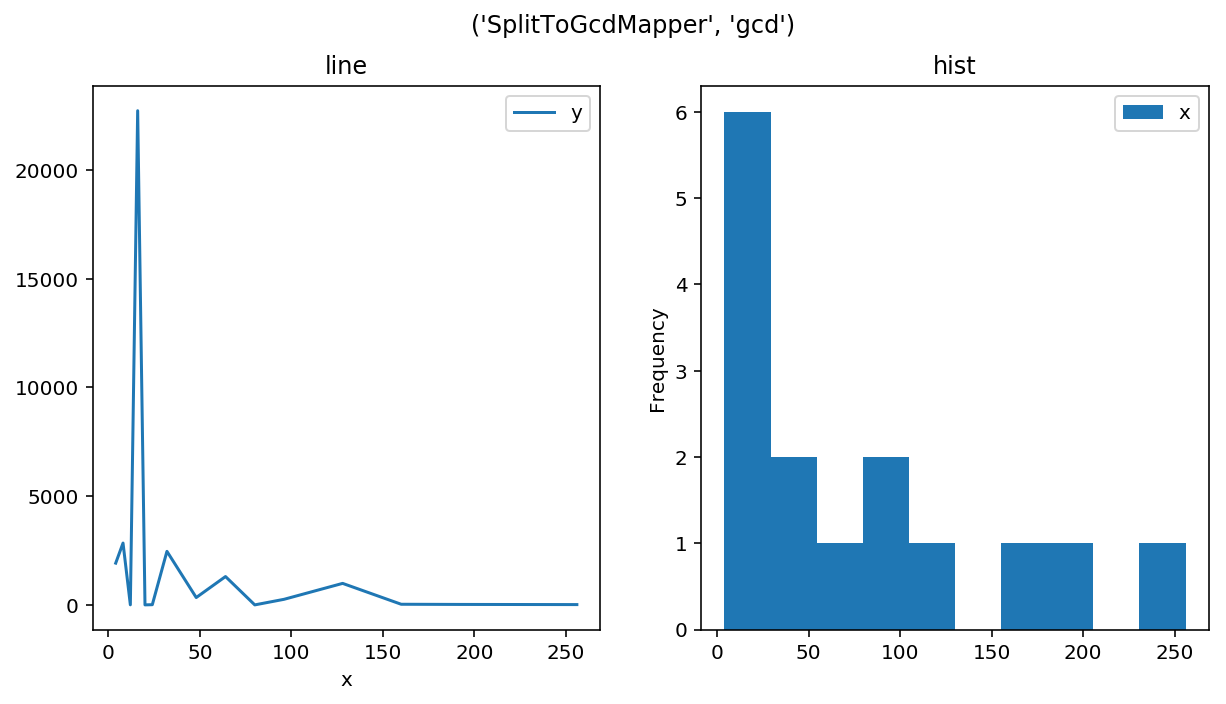

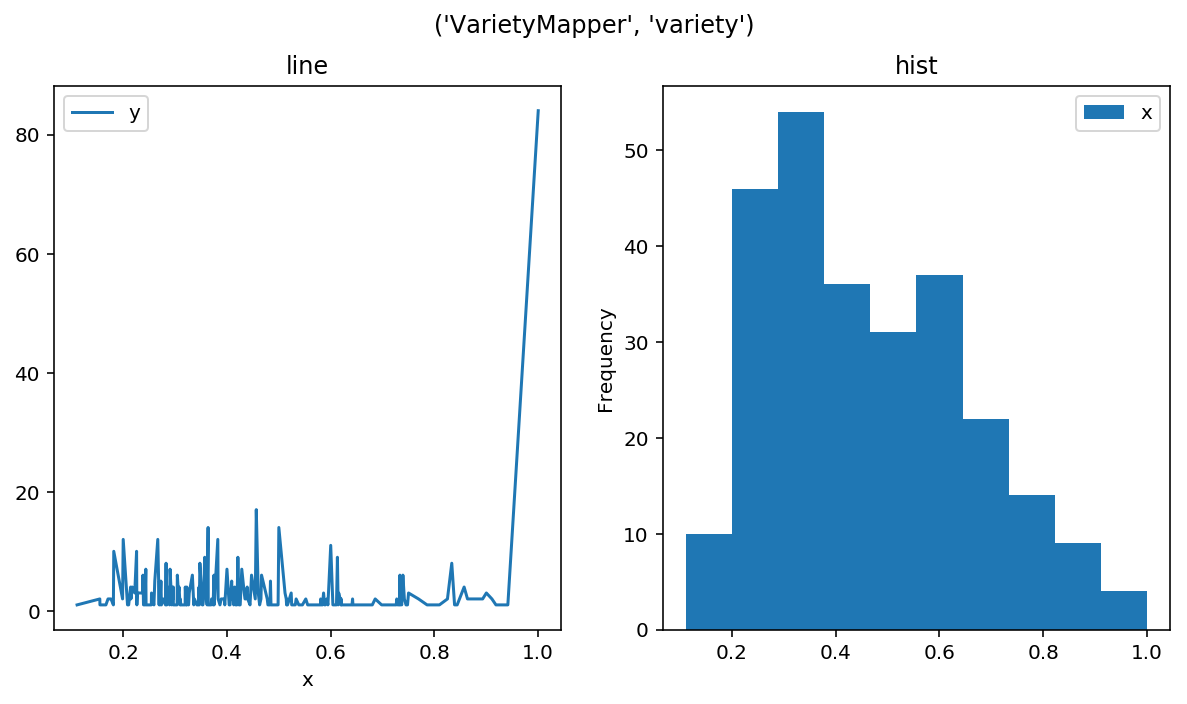

In [6]:
corpus.pipeline.plot_all_stat()

In [5]:
len(corpus.songs)

536

In [6]:
corpus.songs[0]

[51,
 57,
 66,
 59,
 52,
 55,
 64,
 59,
 52,
 56,
 64,
 59,
 52,
 57,
 64,
 60,
 50,
 57,
 66,
 62,
 50,
 55,
 67,
 59,
 53,
 57,
 64,
 60,
 52,
 55,
 64,
 59,
 51,
 57,
 66,
 59]

In [12]:
s = corpus.songs[6].get_music21_repr()

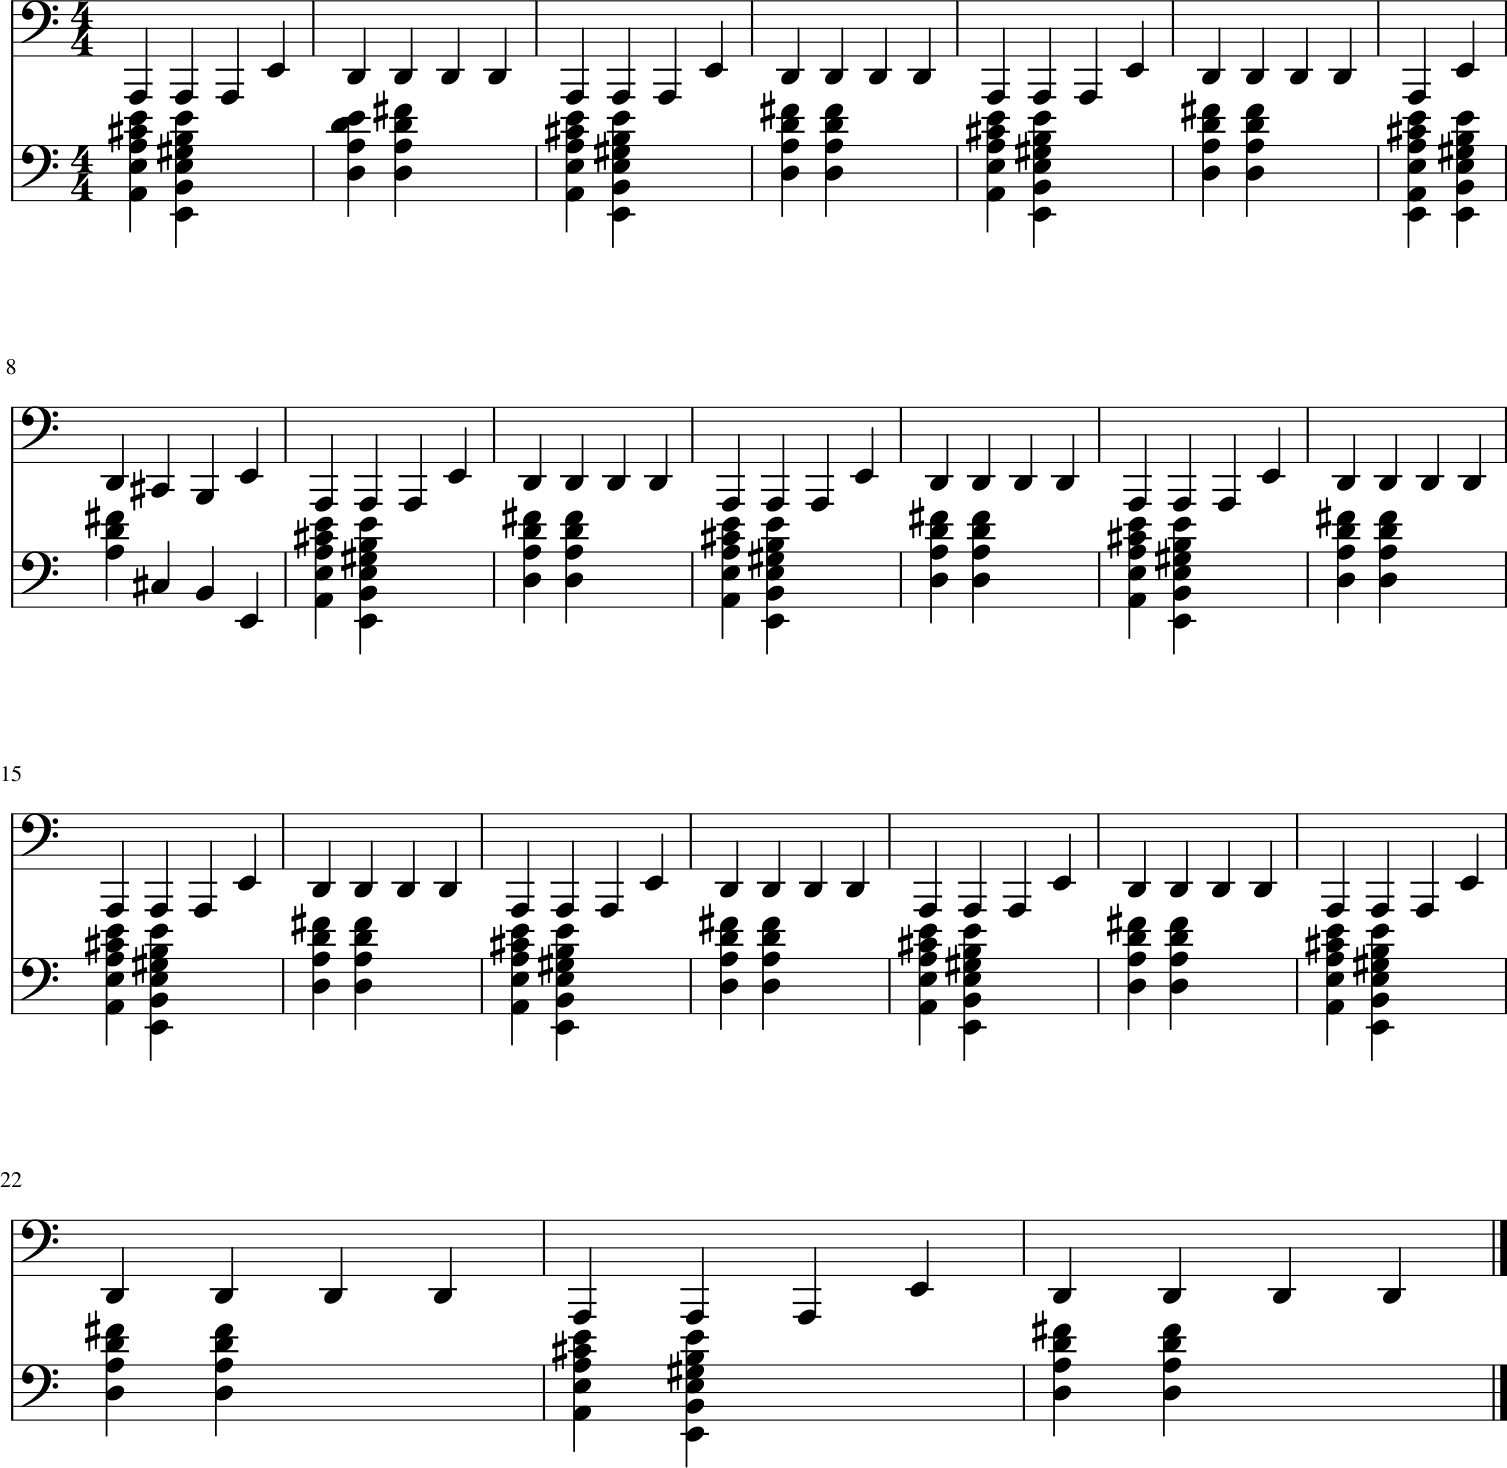

In [13]:
s.show()

In [15]:
for c in s[1]:
    c.volume.velocity /= 2

In [16]:
s[1][0].volume

<music21.volume.Volume realized=0.22>

In [17]:
s.show('midi')

In [8]:
corpus.save_to_file('/home/sharik/code/Innprak/simple_dataset/guitar_forest_dataset.pickle')

In [20]:
def cut_song(song, len_sample=10):
    notes = np.array(song[0])
    chords = np.array(song[1])
    n = len(song[0])
    
    X, y = np.ndarray(shape=(0, len_sample*2)), []
    for i in range(0, n-len_sample):
        X_notes = notes[i:i+len_sample]
        X_chords = chords[i:i+len_sample]
        
        X_cur = np.hstack([X_notes, X_chords])
        y_cur = chords[i+len_sample]
        
        X = np.vstack([X, X_cur])
        y.append(y_cur)
    return X, y

In [21]:
len_sample = 10
X, y = np.ndarray(shape=(0, len_sample*2)), []
for song in tqdm.tqdm_notebook(learning_songs):
#     try:
    if len(song[0]) > len_sample:
        X_, y_ = cut_song(song, len_sample)
        X = np.vstack([X, X_])
        y = np.hstack([y, y_])
#     except ValueError as e:
#         print("Something wrong:", e)
#         #print(song)
        

HBox(children=(IntProgress(value=0, max=12356), HTML(value='')))

KeyboardInterrupt: 

In [22]:
def cut_song2(song, num_tacts, l_min_note, with_chords=True, delay=4):  # 3 arrays: notes, chords, beat
    l_piece = num_tacts * l_min_note
    #print('l_piece', l_piece)
    notes = np.array(song[0])
    chords = np.array(song[1])
    n = len(song[0])
    #print('n', n, len(song[1]))
    n_items = n // l_piece - 1
    #print('n_items', n_items)
    #print('n_items*l_piece', n_items*l_piece)
    X_notes = notes[:n_items * l_piece].reshape((n_items, l_piece))[:, :-delay]
    X_chords = chords[:n_items * l_piece].reshape((n_items, l_piece))[:, :-delay]

    X = np.hstack([X_notes, X_chords])
    y = np.array([chords[l_piece * (i + 1) + 1] for i in range(n_items)])
    return X, y

In [23]:
songs = learning_songs
n_tacts = 2
X, y = np.ndarray(shape=(0, 56)), []
for song in tqdm.tqdm_notebook(songs):
#     try:
    if len(song[0]) > 32:
        X_, y_ = cut_song2(song, n_tacts, 16, with_chords=True)
        X = np.vstack([X, X_])
        y = np.hstack([y, y_])
#     except ValueError as e:
#         print("Something wrong:", e)
#         #print(song)
        

In [24]:
X.shape, y.shape

((246, 56), (246,))

In [25]:
print(X[0], y[0])
print(X.shape, y.shape)
np.save('X_simple_my.npy', X)
np.save('y_simple_my.npy', y)

['51' '57' '66' '59' '52' '55' '64' '59' '52' '56' '64' '59' '52' '57'
 '64' '60' '50' '57' '66' '62' '50' '55' '67' '59' '53' '57' '64' '60'
 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'E4' 'A4' 'A4'
 'A4' 'A4' 'D4' 'D4' 'D4' 'D4' 'G4' 'G4' 'G4' 'G4' 'F4' 'F4' 'F4' 'F4'] E4
(246, 56) (246,)
